# Anomaly detection

In this project we set out to answer some questions regarding the access logs of the CodeUp curriculum

## Imports

These are the necessary imports for the project 

In [1]:
# Append path to import .py file outside directory
import sys
sys.path.append('/Users/nickolaspedrimiranda/CodeUp/curriculum')

In [21]:
# DS imports
import pandas as pd
import numpy as np

# Visual imports
import seaborn as sns
import matplotlib.pyplot as plt

import os
# Set the working directory to the directory containing your notebook
os.chdir('/Users/jongarcia/codeup-data-science/curriculum')

import johns_visual as vis


ModuleNotFoundError: No module named 'johns_visual'

## Acquire

To acquire we simply read in the data from a .csv file

In [3]:
# Read .csv from main directory
df = pd.read_csv('anonymized-curriculum-access.txt', sep=' ')

cohort = pd.read_csv('cohorts.csv')

## Prepare

Data preparation will simply be dropping a few columns and renaming them and filling a few nulls

In [4]:
# Rename columns
names = {'2018-01-26':'date', '09:55:03':'time', '/':'path', '1':'user_id', '8':'cohort_id', '97.105.19.61':'ip'}

df = df.rename(columns=names)

# Merge tables
df = df.merge(cohort, how='left', left_on='cohort_id', right_on='id')

# Drop path nulls
df= df[df.path.notna()]

# Convert to datetime
df['date'] = df.date + ' ' + df.time
df.date = pd.to_datetime(df.date)
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)

# Drop useless data
df = df.drop(columns=['deleted_at', 'time','id', 'created_at', 'updated_at'])

df.head(3)

,date,path,user_id,cohort_id,ip,name,slack,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0


In [5]:
df.isna().sum()  # Check for nulls

date              0
path              0
user_id           0
cohort_id     52893
ip                0
name          52893
slack         52893
start_date    52893
end_date      52893
program_id    52893
dtype: int64

In [6]:
# Create separate df without nulls
df1 = df[df.cohort_id.notnull()]

df1 = df1.dropna()

df1.cohort_id = df1.cohort_id.astype(int)
df1.program_id = df1.program_id.astype(int)

In [7]:
df1.head(3)

,date,path,user_id,cohort_id,ip,name,slack,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1


In [8]:
# Create column that specifies if page was accessed when student was still in the cohort or not
activity = []
for (s,c,e) in zip(df1.start_date, df1.date, df1.end_date):
    if s <= c <= e:
        activity.append('Active')
    else:
        activity.append('Inactive')

In [9]:
df1['activity']= activity

In [10]:
df1.head()

,date,path,user_id,cohort_id,ip,name,slack,start_date,end_date,program_id,activity
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1,Inactive
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1,Inactive
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1,Inactive
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2,Active
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2,Active


## Questions

### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [11]:
df_john =pd.read_csv('df.csv')

In [14]:
# Group by 'program_id' and 'path', then count the occurrences to identify the most visited lesson per program
traffic_program = df_john.groupby(['program_id', 'path_first']).size().reset_index(name='visit_count')
traffic_program= traffic_program[traffic_program['path_first'] != '/']
traffic_program.sort_values('visit_count', ascending=False).head(5)

,program_id,path_first,visit_count
565,2,javascript-i,110118
544,2,html-css,79001
596,2,mysql,77340
571,2,jquery,56787
643,2,spring,53149


In [15]:
# List of common file extensions
file_extensions = ['.txt', '.jpg', '.jpeg', '.png', '.pdf', '.doc', '.xls', '.csv', '.json', '.html', '.svg', '.java', '.zip', '.gif', '.ico']

# Define a function to check if a URL contains a file extension
def contains_file_extension(url):
    for ext in file_extensions:
        if ext in url:
            return False
    return True

# Filter rows where the URL doesn't contain a file extension
traffic_program = traffic_program[traffic_program['path_first'].apply(contains_file_extension)]
traffic_program.sort_values('visit_count', ascending=False).head(5)

,program_id,path_first,visit_count
565,2,javascript-i,110118
544,2,html-css,79001
596,2,mysql,77340
571,2,jquery,56787
643,2,spring,53149


In [16]:
# Sort the DataFrame by 'program_id' and 'visit_count' to get the top 10 most visited lessons per program
traffic_program_sorted = traffic_program.sort_values(['program_id', 'visit_count'], ascending=[True, False])
traffic_program_full_path = traffic_program_sorted.copy()

# traffic_program_sorted['path'] = traffic_program_sorted['path'].str[:15]
traffic_program_sorted.head()

,program_id,path_first,visit_count
49,1,content,6397
67,1,javascript-i,3708
56,1,html-css,2463
86,1,spring,2324
75,1,mysql,2067


NameError: name 'vis' is not defined

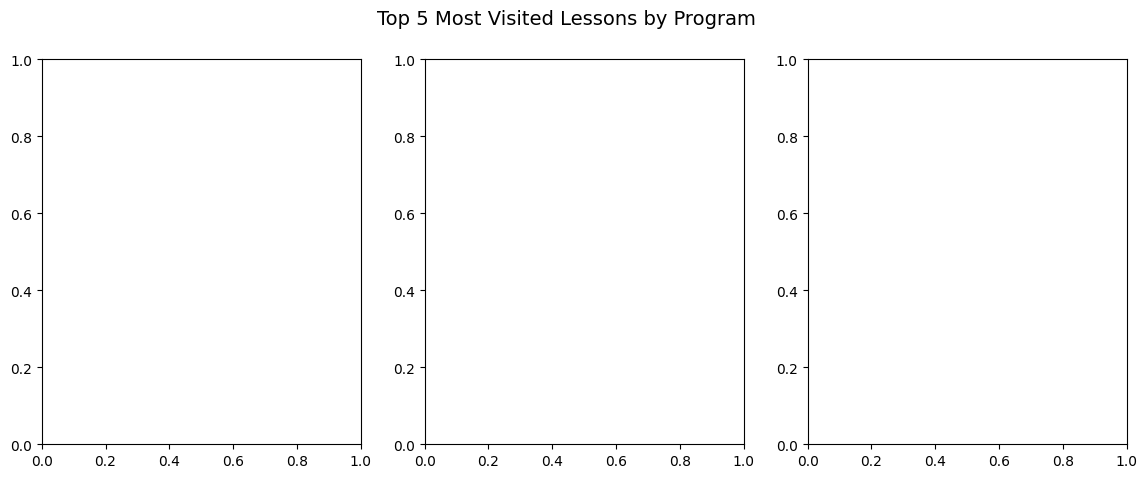

In [17]:
# Create subplots for each program's top 5 most visited lessons using johns_barsubplot
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Top 5 Most Visited Lessons by Program', fontsize=14)

# Flatten axes for easy iteration
axes = axes.flatten()

# Program IDs
program_ids = [1, 2, 3]

for i, program_id in enumerate(program_ids):
    # Get the top 5 most visited lessons for the current program
    top_5_per_program = traffic_program_sorted[traffic_program_sorted['program_id'] == program_id].head()
    
    # Create the bar plot using the top 5 most visited lessons for the current program
    ax = axes[i]
    vis.johns_barsubplot(ax, x='path', y='visit_count', data=top_5_per_program, 
                     title=f'Program: {program_id}', xlabel='', single_color='#1f77b4', x_label_rotation= 35)

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# Check number of unique programs
ids = df1.program_id.unique()
df1.program_id.nunique()

4

There are 4 different programs

In [12]:
# Create a little filter to ignore homepage and json files
dot = df1.path.str.contains('.json')
slash = df1.path != '/'
n_dot = [not elem for elem in dot]

In [13]:
clean_df = df1[n_dot & slash]  # Create clean df

In [14]:
# Loop to check most accessed page per program
for program in ids:
    print(f'Program id: {program}')
    print(clean_df[clean_df.program_id == program].path.value_counts()[:3])
    print()
    print()

Program id: 1
index.html      1011
javascript-i     736
html-css         542
Name: path, dtype: int64


Program id: 2
javascript-i    17457
toc             17428
java-iii        12683
Name: path, dtype: int64


Program id: 4
content/html-css                               2
content/html-css/gitbook/images/favicon.ico    1
content/html-css/introduction.html             1
Name: path, dtype: int64


Program id: 3
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg        1651
Name: path, dtype: int64




The lesson that appears the most for each program is:
* 1: javascript-i
* 2: javascript-i
* 3: content/html-css
* 4: classification/overview

### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

To check this, we will create a dataframe that details how many time each page(path) was accessed by each cohort

In [15]:
# Create empty df and add path column
gg = pd.DataFrame()
gg['path'] = df1.path

In [16]:
# Loop through every cohort name creating a column for each and returning true for if the pach access was made by that cohort
for cohort in df1.cohort_id.unique():
    gg[f'cohort_{cohort}'] = df1.cohort_id == cohort

In [17]:
# Group by path
counts = gg.groupby('path').sum()

In [18]:
counts.head(3)

,cohort_8,cohort_22,cohort_21,cohort_1,cohort_16,cohort_18,cohort_19,cohort_13,cohort_14,cohort_15,...,cohort_59,cohort_61,cohort_62,cohort_132,cohort_134,cohort_133,cohort_135,cohort_138,cohort_137,cohort_139
path,,,,,,,,,,,,,,,,,,,,,
%20https://github.com/RaulCPena,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
",%20https://github.com/RaulCPena",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Create function to access top counts for each page separated by cohort
def access_counts(page,top=None):
    print(counts.loc[page].sort_values(ascending=False)[:top])

In [20]:
access_counts('javascript-i', 5)  # Top 5 cohorts accessing 'javascript-i'

cohort_28     1817
cohort_33     1003
cohort_62      926
cohort_58      910
cohort_135     907
Name: javascript-i, dtype: int64


In [21]:
access_counts('classification/overview', 5)  # Top 5 cohorts accessing 'classification/overview'

cohort_59     1109
cohort_28      851
cohort_133     445
cohort_55      136
cohort_137      60
Name: classification/overview, dtype: int64


In [22]:
access_counts('toc', 5)  # Top 5 cohorts accessing 'toc'

cohort_62    1866
cohort_29    1465
cohort_53    1293
cohort_58    1022
cohort_25     991
Name: toc, dtype: int64


It does seem that each cohort varies in number of accesses. There is nothing too out of the ordinary for any specific cohort. 

### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [23]:
df1.user_id.nunique()  # Identify number of unique users

911

There are 911 unique users

In [24]:
# Use groupby to count how many times each user_id accessed the curriculum
# Use 'Active' in activity column to only see students who are active
least_active = df1[df1.activity == 'Active'].groupby('user_id').path.count().sort_values()

In [25]:
df1[df1.user_id == least_active.index[0]]

,date,path,user_id,cohort_id,ip,name,slack,start_date,end_date,program_id,activity
847371,2021-03-15 16:59:56,/,918,138,71.221.46.112,Neptune,#neptune,2021-03-15,2021-09-03,2,Active


We can access any information we want from each student user_id. For example ^ one of the least active student accessed the curriculum one singular time and he/she only viewed the home page. He/she was part of cohort 138  and program 2

### 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [26]:
# Fill all nulls in cohot id with 0
df.cohort_id = df.cohort_id.fillna(0)

In [27]:
df.ip.value_counts()[:10]  # Check top used ips

97.105.19.58       284579
97.105.19.61        61661
192.171.117.210      9515
71.150.217.33        6791
76.185.145.231       4754
12.106.208.194       4360
67.11.50.23          4181
70.112.179.142       4117
70.121.183.95        3843
172.124.67.93        3511
Name: ip, dtype: int64

In [28]:
# Create df with only the missing cohort ids
unk = df[df.cohort_id == 0]
unk.index = unk.date
unk_avg = unk.resample('w').count()

There are two ips accessing the curriculum an extraordinary amount of times

In [29]:
# Create avg group that excludes the top 2 ips
avg = df.copy()
avg = avg[ (avg.ip != '97.105.19.58') & (avg.ip != '97.105.19.61') ]
avg.index = avg.date
week_avg = avg.resample('w').count()

In [30]:
# Create two df of the suspicious ips
sus1 = df1[(df1.ip == '97.105.19.58')]
sus2 = df1[(df1.ip == '97.105.19.61')]

sus1.index = sus1.date
sus2.index = sus2.date

week_sus1 = sus1.resample('w').count()
week_sus2 = sus2.resample('w').count()

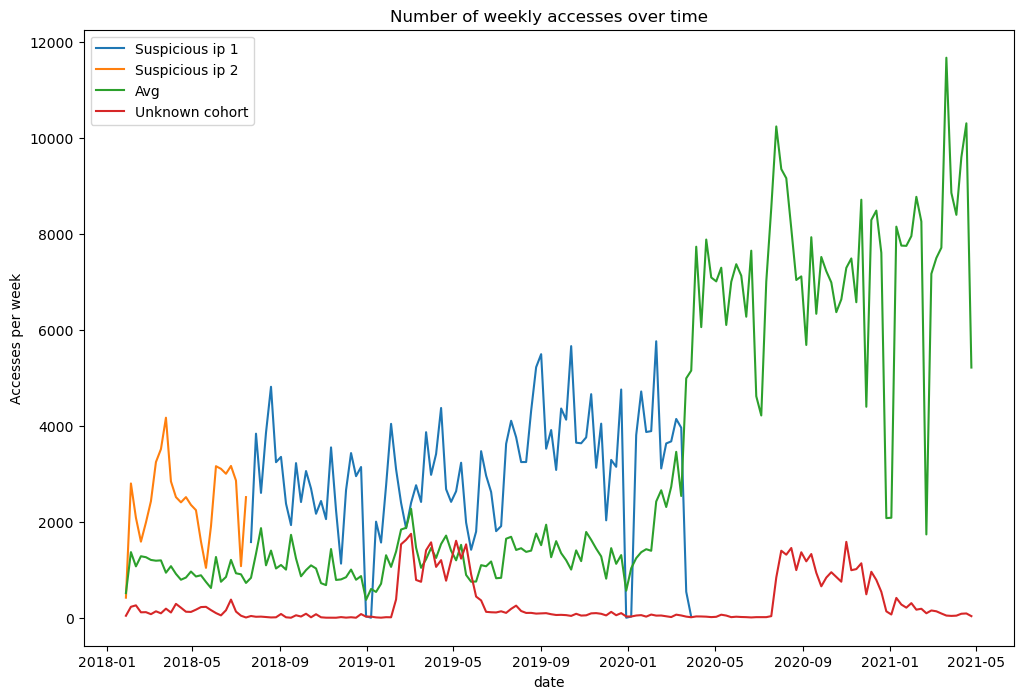

In [31]:
plt.figure(figsize=(12,8))
sns.lineplot(week_sus1.path, label='Suspicious ip 1')
sns.lineplot(week_sus2.path, label='Suspicious ip 2')
sns.lineplot(week_avg.path, label='Avg')
sns.lineplot(unk_avg.path, label='Unknown cohort')
plt.legend()
plt.ylabel('Accesses per week')
plt.title('Number of weekly accesses over time')
plt.show()

In [32]:
unk.ip.value_counts()[:5]

97.105.19.58     15931
70.117.16.60      1903
67.11.117.74      1729
70.94.165.107     1715
23.116.170.48     1616
Name: ip, dtype: int64

In [33]:
unk.path.value_counts()[:5]

/                           4459
search/search_index.json    1985
javascript-i                 780
toc                          706
spring                       641
Name: path, dtype: int64

In [34]:
unk.user_id.nunique()

78

In [35]:
unk.user_id.value_counts()[:5]

354    2965
736    2358
363    2248
716    2136
368    2085
Name: user_id, dtype: int64

There does not seem to be anything abnormal at first glance. There are two ips with a huge number of accesses but these are likely the CodeUp wifi that is shared by all students in class. These ips disappear when covid strikes and everyone has to do remote learning on their own homes and the avg of other ips rises. The unknown cohorts dont have anything alarming at first sight. It seems that there was a cohort at some point that their cohort id was not registered. This happens twice.

### 5. At some point in 2019, the ability for students and alumni to access both curricula (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [36]:
# Check if all access dates are after start dates
(df1.date < df1.start_date).sum()

0

In [37]:
# Filter by ativity, to see students that accessed the curriculum after graduating
grads = df1[df1.activity == 'Inactive']

In [38]:
# Filter away home page and .json files
dot = grads.path.str.contains('.json')
slash = grads.path != '/'
n_dot = [not elem for elem in dot]
grads = grads[n_dot & slash]

In [39]:
# Loop through most accessed lessons
for program in ids:
    print(f'Program id: {program}')
    print(grads[grads.program_id == program].path.value_counts()[:3])
    print()
    print()

Program id: 1
index.html      1011
javascript-i     736
html-css         542
Name: path, dtype: int64


Program id: 2
javascript-i    4233
spring          3771
html-css        3145
Name: path, dtype: int64


Program id: 4
content/html-css                               2
content/html-css/gitbook/images/favicon.ico    1
content/html-css/introduction.html             1
Name: path, dtype: int64


Program id: 3
sql/mysql-overview                          275
classification/overview                     267
classification/scale_features_or_not.svg    220
Name: path, dtype: int64




Some of the most accessed lesson by students post graduation are:
* javascript-i
* spring
* content/html-css
* sql/mysql-overview

### 7. Which lessons are least accessed?

In [40]:
for program in ids:
    print(f'Program id: {program}')
    print(clean_df[clean_df.program_id == program].path.value_counts(ascending=True)[:10])
    print()
    print()

Program id: 1
ajax-api-request.html                             1
2.00.05_Charts_PivotTables_Sparklines             1
2.00.02_Navigating_Excel                          1
student/create                                    1
content/examples/constructors-destructors.html    1
student                                           1
html-css/media-queries                            1
php                                               1
mysql/jdbc-statements                             1
mysql/intro-jdbc                                  1
Name: path, dtype: int64


Program id: 2
appendix/professional-development/post-interview-review-form    1
cli-03-file-paths                                               1
cli-07-more-topics                                              1
spring/services                                                 1
spring/security                                                 1
8-timeseries/1-overview                                         1
8-timeseries/2-intro-to-times

### 8. Anything else I should be aware of?